# **Imports e Definições**


In [1]:
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import glob
from torch.utils.data import Dataset
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mlstac
import segmentation_models_pytorch as smp
import pdb
import rasterio
import rioxarray

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Função para normalização das bandas para plot.**

In [2]:
def normalize_band(band, stretch_factor=1.5):
    """
    Normalizes a band and stretches contrast.

    Args:
        band: A numpy array representing the band data.
        stretch_factor: A factor to control the amount of contrast stretching (default: 1.5).

    Returns:
        A numpy array with normalized and stretched band values.
    """
    return (band - band.min()) / (band.max() - band.min()) * stretch_factor

## **Criação do Dataset com os paths das imagens**

In [3]:
# Listar arquivos de treino, validação e teste para as imagens de 512x512
train_files_512 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p509\high\train_br\*.tif"
)
val_files_512 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p509\high\val_br\*.tif"
)
test_files_512 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p509\high\test_br\*.tif"
)

# Listar arquivos de treino, validação e teste para as imagens de 2048x2048
train_files_2048 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p2000\train_br\*.tif"
)
val_files_2048 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p2000\val_br\*.tif"
)
test_files_2048 = glob.glob(
    r"C:\Users\alanb\Documents\CloudSen12_Br_Resized\p2000\test_br\*.tif"
)

# Concatenando os conjuntos de treino, validação e teste
train_files = train_files_512 + train_files_2048
val_files = val_files_512 + val_files_2048
test_files = test_files_512 + test_files_2048

# Criar DataFrames e adicionar a coluna 'set_type'
train_df = pd.DataFrame(train_files, columns=["file_path"])
train_df["set_type"] = "train"

val_df = pd.DataFrame(val_files, columns=["file_path"])
val_df["set_type"] = "val"

test_df = pd.DataFrame(test_files, columns=["file_path"])
test_df["set_type"] = "test"

# Concatenar todos os DataFrames
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## **Visualização de uma imagem para teste**

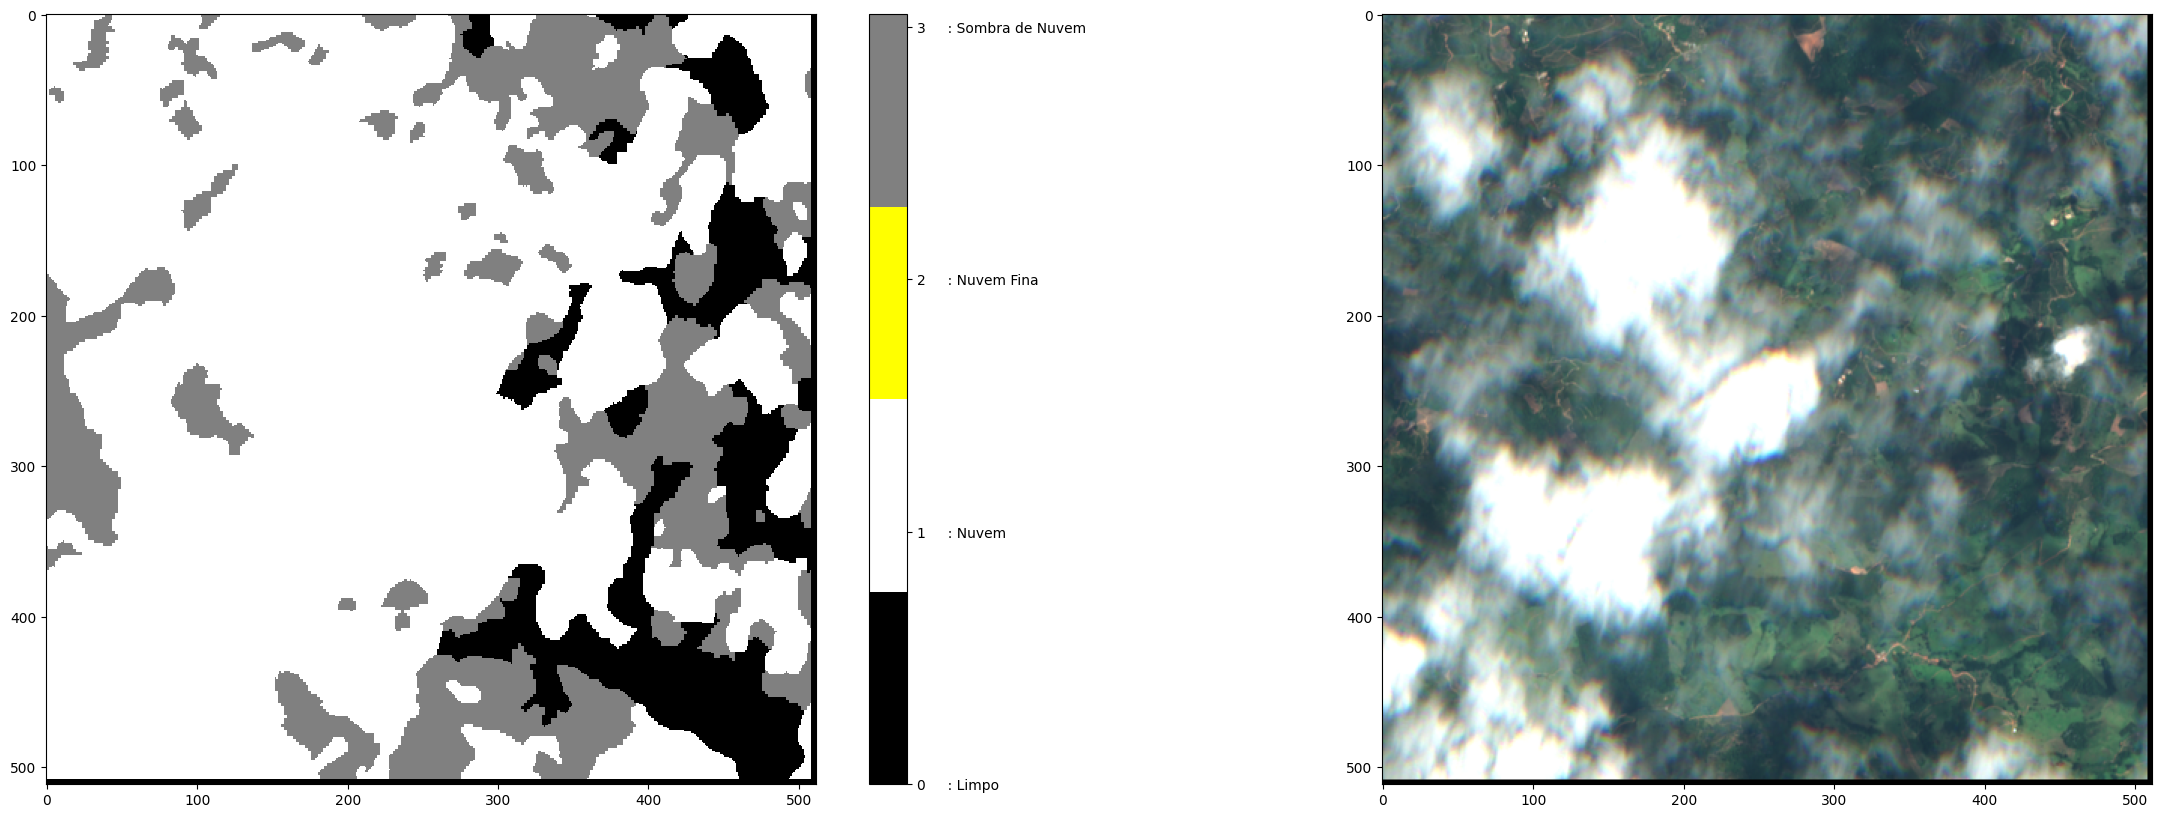

In [4]:
src = rasterio.open(df["file_path"][0])
# Ler todas as bandas
sample = src.read()
b_r = normalize_band(sample[3], stretch_factor=1)
b_g = normalize_band(sample[2], stretch_factor=1)
b_b = normalize_band(sample[1], stretch_factor=1)
rgb_composite_raw = (np.dstack((b_r, b_g, b_b)) * 1.5).clip(0, 1)

colors = {
    0: "black",  # Limpo
    1: "white",  # Nuvem
    2: "yellow",  # Nuvem Fina
    3: "gray",  # Sombra de Nuvem
}

labels = ["Limpo", "Nuvem", "Nuvem Fina", "Sombra de Nuvem"]  # 0  # 1  # 2  # 3

mascara_de_classificacao = sample[13]

max_color_len = max(len(color) for color in colors.values())

# Cria uma lista de cores para a visualização usando Matplotlib
cmap = ListedColormap([colors[i] for i in colors])

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
im = ax[0].imshow(
    mascara_de_classificacao,
    cmap=cmap,
    interpolation="none",
    vmin=0,
    vmax=max(colors) + 0.05,
)
colorbar = plt.colorbar(
    im,
    ax=ax[0],
    ticks=list(colors.keys()),
    format=lambda x, pos: f"{x: <{max_color_len}}: {labels[x]}",
)

ax[1].imshow(rgb_composite_raw)

# **Data Module**

In [5]:
class CoreDataset(Dataset):
    def __init__(self, subset: pd.DataFrame):
        subset.reset_index(drop=True, inplace=True)
        self.subset = subset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index: int):
        # Obter o caminho do arquivo a partir do DataFrame
        img_path = self.subset.iloc[index]["file_path"]

        # Lê todas as bandas da imagem
        bandas = rasterio.open(img_path).read()

        # Transforma em array numpy
        bandas = np.array(bandas)

        # Assumindo que as bandas estão nos primeiros canais
        X = bandas[0:13, :, :].astype(np.float32) / 10000

        # Assumindo que o alvo está no canal 14 (index 13)
        y = bandas[13, :, :].astype(np.int64)

        return X, y

In [6]:
class CoreDataModule(pl.LightningDataModule):
    def __init__(self, dataframe: pd.DataFrame, batch_size: int = 4):
        super().__init__()

        # Separar o DataFrame em datasets de treino, validação e teste
        self.train_dataset = dataframe[dataframe["set_type"] == "train"]
        self.validation_dataset = dataframe[dataframe["set_type"] == "val"]
        self.test_dataset = dataframe[dataframe["set_type"] == "test"]

        # Definir o batch_size
        self.batch_size = batch_size

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.train_dataset),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.validation_dataset), batch_size=self.batch_size
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.test_dataset), batch_size=self.batch_size
        )

## **2. Define a Model**

In [7]:
class litmodel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="mobilenet_v2", encoder_weights=None, classes=4, in_channels=13
        )
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

## **3. Define the Trainer**

In [8]:
# Define the callbacks
callbacks = [
    pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=3),
    pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
]

# Define the trainer
trainer = pl.Trainer(
    max_epochs=10, callbacks=callbacks, accelerator="auto", precision="16-mixed"
)

# Define the datamodule
datamodule = CoreDataModule(dataframe=df, batch_size=2)

# Define the model
model = litmodel()

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
# Start the training
trainer.fit(model=model, datamodule=datamodule)


  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Unet             | 6.6 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.529    Total estimated model params size (MB)
285       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 1/222 [05:34<20:32:44,  0.00it/s, v_num=2]

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, datamodule=datamodule, verbose=True)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(model, datamodule=datamodule, verbose=True)
print(test_metrics)

In [ ]:
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
smp_model.save_pretrained("./unet_br")